In [1]:
from time import time

import numpy as np

import matplotlib.pyplot as plt

In [2]:
TIME_DELTA = 0.01
FINISH_PROCESS_REQUEST = 1
СURRENT_REQUEST = 0
DONT_HAVE_FREE_OPERATOR = -1

In [3]:
%matplotlib inline
# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('pdf')

In [4]:
class TimeSeries:
    def __init__(self, step: np.float64 = TIME_DELTA):
        self.time = 0
        self.step = step
        self.times = []
        self.counts = []

    def update_time(self):
        self.time += self.step

    def add(self) -> None:
        self.put(self.time, self.counts[-1] + 1 if len(self.counts) > 0 else 1)

    def put(self, at: np.float64, val: np.int64) -> None:
        self.times.append(at)
        self.counts.append(val)

    def raw(self):
        return self.times, self.counts

In [5]:
def distribution(a, b):
    return lambda: np.random.uniform(a - b, a + b)

In [6]:
class ClientGenerator:
    def __init__(self, time_distribution):
        self.time_distribution = time_distribution
        self.remaining_time = 0
        self.stat = TimeSeries()

    def update_time(self):
        self.stat.update_time()
        if self.remaining_time > 0:
            self.remaining_time -= TIME_DELTA

        if self.remaining_time <= 1e-5:
            self.remaining_time = self.time_distribution()
            self.stat.add()
            return Request()

        return None

In [7]:
class Operator:
    def __init__(self, recipients, time_distribution):
        self.time_distribution = time_distribution
        self.recipients = recipients
        self.remaining_time = 0
        self.is_busy = False
        self.processing_request = None
        self.stat = TimeSeries()

    def update_time(self):
        self.stat.update_time()
        self.remaining_time -= TIME_DELTA
        if self.is_busy and self.remaining_time <= 1e-5:
            self.finish_process_request()

    def start_process_new_request(self, request):
        self.is_busy = True
        self.processing_request = request
        self.remaining_time = self.time_distribution()

    def finish_process_request(self):
        min(self.recipients, key=len).append(self.processing_request)
        self.is_busy = False
        self.processing_request = None
        self.stat.add()

In [8]:
class Request:
    request_id = 0

    def __init__(self):
        global СURRENT_REQUEST
        self.request_id = СURRENT_REQUEST
        СURRENT_REQUEST += 1

In [9]:
class Processor:
    def __init__(self, requests_storage, time_distribution):
        self.requests_storage = requests_storage
        self.time_distribution = time_distribution
        self.is_busy = False
        self.processing_request = None
        self.remaining_time = 0
        self.stat = TimeSeries()

    def update_time(self):
        self.stat.update_time()
        if self.remaining_time != 0:
            self.remaining_time -= TIME_DELTA

        if self.is_busy and self.remaining_time <= 1e-5:
            self.is_busy = False
            self.processing_request = None
            self.stat.add()
            return FINISH_PROCESS_REQUEST

        if not self.is_busy and len(self.requests_storage) != 0:
            self.processing_request = self.requests_storage.pop(0)
            self.remaining_time = self.time_distribution()
            self.is_busy = True

In [10]:
def find_free_operator(operators):
    return next(
        (i for i, o in enumerate(operators) if not o.is_busy), DONT_HAVE_FREE_OPERATOR
    )

In [11]:
def iteration(clients, operators, processors, request_info, is_new=True):
    if is_new:
        request = clients.update_time()
        if request:
            request_info['generated_count'] += 1
            free_operator_number = find_free_operator(operators)
            if free_operator_number == DONT_HAVE_FREE_OPERATOR:
                request_info['lost_count'] += 1
            else:
                operators[free_operator_number].start_process_new_request(request)

    for operator in operators:
        operator.update_time()

    for processor in processors:
        result = processor.update_time()
        if result == FINISH_PROCESS_REQUEST:
            request_info['processed_count'] += 1

In [12]:
def modeling(clients, operators, processors, requests_count):
    statistics_info = {'generated_count': 0, 'processed_count': 0, 'lost_count': 0}

    while statistics_info['generated_count'] < requests_count:
        iteration(clients, operators, processors, statistics_info)

    while statistics_info['lost_count'] + statistics_info['processed_count'] < requests_count:
        iteration(clients, operators, processors, statistics_info, False)

    return statistics_info

In [21]:
requests_count = 300

clients = ClientGenerator(distribution(4, 20))

storage_1, storage_2, storage_3, storage_4 = [], [], [], []

processors = [
    Processor(storage_1, distribution(20, 2)),
    Processor(storage_2, distribution(20, 2)),
    Processor(storage_3, distribution(20, 2)),
    Processor(storage_4, distribution(25, 1)),
]

operators = [
    Operator([storage_1, storage_4], distribution(3, 2)),
    Operator([storage_2, storage_4], distribution(5, 1)),
    Operator([storage_3, storage_4], distribution(10, 4)),
]

start_time = time()

result = modeling(clients, operators, processors, requests_count)

print('Processing time (seconds): ', round((time() - start_time), 4))
print('Total requests: ', result['generated_count'])
print('Processed requests: ', result['processed_count'])
print('Canceled requests: ', result['lost_count'])
print('Cancelation percent: ', round((result['lost_count'] / requests_count), 4))

Processing time (seconds):  0.8914
Total requests:  300
Processed requests:  269
Canceled requests:  31
Cancelation percent:  0.1033


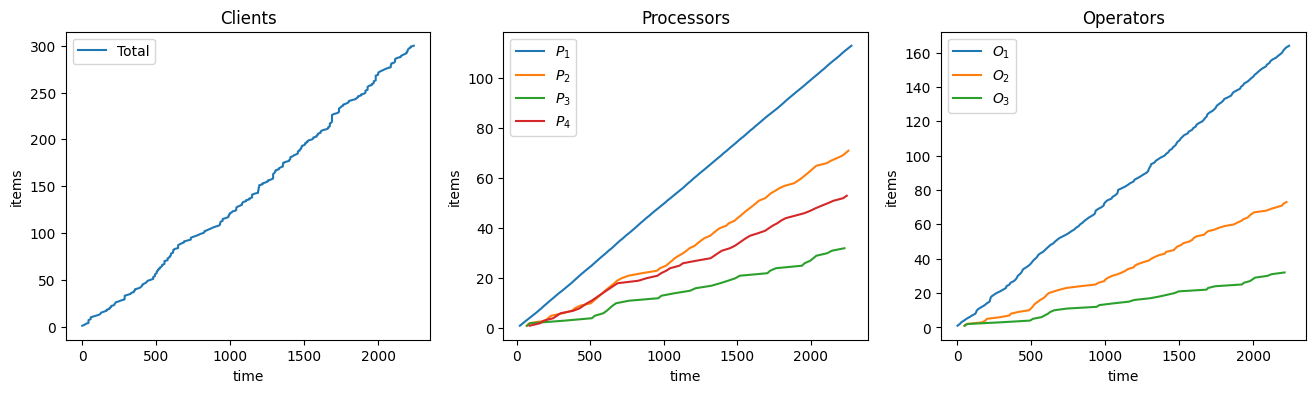

In [22]:
fig, axis = plt.subplots(1, 3, figsize=(16,4))

axis[0].set_title("Clients")
axis[0].plot(*clients.stat.raw(), label="Total")
axis[0].set_xlabel("time")
axis[0].set_ylabel("items")
axis[0].legend()

axis[1].set_title("Processors")
axis[1].set_xlabel("time")
axis[1].set_ylabel("items")
for i, p in enumerate(processors):
    axis[1].plot(*p.stat.raw(), label=f"$P_{i+1}$")
axis[1].legend()

axis[2].set_title("Operators")
axis[2].set_xlabel("time")
axis[2].set_ylabel("items")
for i, o in enumerate(operators):
    axis[2].plot(*o.stat.raw(), label=f"$O_{i+1}$")
axis[2].legend()
    
plt.show()